In [16]:
import geopandas as gpd
import pandas as pd
import numpy as np
import contextily as cx

import nomad.stop_detection.dbscan as DBSCAN
import nomad.stop_detection.lachesis as LACHESIS
import nomad.stop_detection.grid_based as GRID_BASED
import nomad.filters as filters
import nomad.filters as filters
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import shapely.plotting as shp_plt
from IPython.display import HTML
from nomad.stop_detection.viz import plot_stops_barcode, plot_pings, plot_stops, plot_time_barcode

from metpy.calc import heat_index
from metpy.units import units
from matplotlib import pyplot as plt
from tqdm import tqdm
from nomad.map_utils import download_osm_buildings, download_osm_streets, remove_overlaps

## Load Census Block Group Data

In [8]:
df_cbg = gpd.read_file("https://www2.census.gov/geo/tiger/TIGER2021/BG/tl_2021_36_bg.zip")
nyc_cbg = df_cbg[df_cbg['COUNTYFP'].isin(['005', '047', '061', '081', '085'])]

## Download POI Data from OSM

In [9]:
# get poi data
bbox = (-74.00116,40.61975,-73.89130,40.72486)
buildings = download_osm_buildings(bbox, clip=True, explode=True, infer_building_types=True)
streets = download_osm_streets(bbox, clip=True, explode=True)

buildings = remove_overlaps(buildings)

## Load data on heat emergencies from NYC Emergency Management via Notify NYC Alerts

In [10]:
df_notify_nyc = pd.read_csv(
    "https://data.cityofnewyork.us/resource/8vv7-7wx3.csv?$limit=100000"
)

# identify heat event messages
heat_events_daily = df_notify_nyc[
    (df_notify_nyc["email_body"].notna())
    & (df_notify_nyc["email_body"].str.lower().str.contains("heat"))
    & (df_notify_nyc["email_body"].str.lower().str.contains("heating oil") == False)
    & (df_notify_nyc["notificationtype"] == "Weather")
]
heat_events_daily["date_and_time"] = pd.to_datetime(heat_events_daily["date_and_time"])
heat_events_daily["date"] = heat_events_daily["date_and_time"].dt.date
heat_events_daily = heat_events_daily[heat_events_daily['date_and_time'].dt.year ==2025]

In [11]:
print(heat_events_daily['email_body'].values[-1])

Notification issued 06-21-2025 at 11:37 AM.   The National Weather Service has issued the following:    What:?Extreme Heat Warning?   Where:?NYC?   When:?12 PM?on?6/22?to?8 PM?on?6/24?   Hazards: Heat index values up to 107 degrees expected. These conditions are dangerous to health. People without air conditioning, older adults, people with chronic health conditions, and people who work outside are most at risk.     Preparedness Actions:     - Spend time in a cool place. If you don't have air conditioning, find a cool place to visit nearby, like a friends place, a library, or a NYC cooling center. Visit https://finder.nyc.gov/coolingcenters/ for NYC Cool Options   - Avoid strenuous activity       For more information/safety tips, visit www.NYC.gov/beattheheat       For weather information, visit www.weather.gov/okx      For more information, visit:?https://on.nyc.gov/466Q1l3


## Load NOAA Weather Data

In [12]:
stations = pd.read_fwf(
    "https://www.ncei.noaa.gov/pub/data/ghcn/daily/ghcnd-stations.txt",
    colspecs="infer",
    names=[
        "stationid",
        "latitude",
        "longitude",
        "elevation",
        "state",
        "name",
        "GSN_flag",
        "HCN_CRN_flag",
        "wmo_id",
    ],
)
stations_gdf = gpd.GeoDataFrame(
    stations,
    geometry=gpd.points_from_xy(stations["longitude"], stations["latitude"], crs=4326),
)

stations_gdf = stations_gdf[stations_gdf['stationid'].isin(['USW00094728'])] #['USW00014732', 'USW00094728', 'USW00094789'])]
df_list = []
for station in tqdm(stations_gdf["stationid"].unique()):
    # df = pd.read_fwf(f'https://www.ncei.noaa.gov/pub/data/ghcn/daily/by_station/{station}.csv.gz',
    #                  widths = [11, 8, 4, 5, 1, 1, 1, 4], names=['stationid', 'date', 'element', 'value', 'm_flag', 'q_flag', 's_flag', 'obs_time'])
    df = pd.read_csv(
        f"https://www.ncei.noaa.gov/pub/data/ghcn/daily/by_station/{station}.csv.gz",
        names=[
            "stationid",
            "date",
            "element",
            "value",
            "m_flag",
            "q_flag",
            "s_flag",
            "obs_time",
        ],
    )
    df["date"] = pd.to_datetime(df["date"], format="%Y%m%d")
    df = df[df['date'].dt.year == 2025]
    df_list += [df]
df_weather = pd.concat(df_list)
df_weather.head()

  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/_q/g5l2s5950hz1zr9syt43gzp80000gn/T/ipykernel_39540/260411358.py:26: DtypeWarning: Columns (0: q_flag) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(
100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


,stationid,date,element,value,m_flag,q_flag,s_flag,obs_time
458449,USW00094728,2025-01-01,TMAX,106,NaN,NaN,W,2400.0
458450,USW00094728,2025-01-02,TMAX,61,NaN,NaN,W,2400.0
458451,USW00094728,2025-01-03,TMAX,39,NaN,NaN,W,2400.0
458452,USW00094728,2025-01-04,TMAX,6,NaN,NaN,W,2400.0
458453,USW00094728,2025-01-05,TMAX,6,NaN,NaN,W,2400.0


In [13]:
df_weather = df_weather.groupby(['stationid', 'date', 'element'], as_index=False)['value'].mean()
df_weather_wide = (
    df_weather[
        df_weather["element"].isin(
            [
                "PRCP",
                "SNWD",
                "SNOW",
                "TMIN",
                "TMAX",
                "ADPT",
                "ACMC",
                "ASLP",
                "ASTP",
                "AWBT",
                "TOBS",
                "TAVG",
                "RHAV",
                "RHMN",
                "RHMX",
                'DEWPT',
                'RH',
                'ARH'
            ]
        )
    ]
    .pivot(
        index=["date"], columns=["stationid", "element"], values=["value"]
    )
    .sort_index()
    .reset_index()
)
df_weather_wide.columns = [
    " ".join(col).strip() for col in df_weather_wide.columns.values
]

for col in df_weather_wide.columns:
    if df_weather_wide[col].isna().all():
        df_weather_wide.drop(col, axis=1, inplace=True)

In [14]:
df_weather_wide[df_weather_wide['date']=='2025-06-24']

,date,value USW00094728 PRCP,value USW00094728 SNOW,value USW00094728 SNWD,value USW00094728 TAVG,value USW00094728 TMAX,value USW00094728 TMIN
174,2025-06-24,0.0,0.0,0.0,320.0,372.0,272.0


## Load NOAA Data on Temperature and Relative Humidity (to produce the heat index)

In [17]:
station = 'USW00094728' # STATION FOR CENTRAL PARK
df_lcds = []
for yr in range(2017,2026):
    df_lcds += [pd.read_csv(f"https://www.ncei.noaa.gov/oa/local-climatological-data/v2/access/{yr}/LCD_{station}_{yr}.csv")]
df_lcd = pd.concat(df_lcds, axis=0)
df_lcd['full_date'] = pd.to_datetime(df_lcd['DATE'])
df_lcd['date'] = pd.to_datetime(df_lcd['full_date']).dt.date
df_lcd['HourlyDryBulbTemperature'] = (df_lcd['HourlyDryBulbTemperature']*9/5) + 32
df_lcd['heat_index'] = heat_index(df_lcd['HourlyDryBulbTemperature'].values * units.degF, df_lcd['HourlyRelativeHumidity'].values * units.percent)
df_lcd = df_lcd[['STATION', 'full_date', 'date', 'heat_index']]
df_lcd_daily = df_lcd.groupby(['date'], as_index=False)['heat_index'].max().rename({'heat_index':'heat_index_mean'})

/var/folders/_q/g5l2s5950hz1zr9syt43gzp80000gn/T/ipykernel_39540/3470057238.py:4: DtypeWarning: Columns (0: MonthlyGreatestSnowfall, 1: MonthlyTotalSnowfall) have mixed types. Specify dtype option on import or set low_memory=False.
  df_lcds += [pd.read_csv(f"https://www.ncei.noaa.gov/oa/local-climatological-data/v2/access/{yr}/LCD_{station}_{yr}.csv")]
/var/folders/_q/g5l2s5950hz1zr9syt43gzp80000gn/T/ipykernel_39540/3470057238.py:4: DtypeWarning: Columns (0: DailySnowDepth, 1: MonthlyGreatestSnowfall, 2: MonthlyTotalSnowfall) have mixed types. Specify dtype option on import or set low_memory=False.
  df_lcds += [pd.read_csv(f"https://www.ncei.noaa.gov/oa/local-climatological-data/v2/access/{yr}/LCD_{station}_{yr}.csv")]
/var/folders/_q/g5l2s5950hz1zr9syt43gzp80000gn/T/ipykernel_39540/3470057238.py:4: DtypeWarning: Columns (0: MonthlyGreatestSnowfall, 1: MonthlyTotalSnowfall) have mixed types. Specify dtype option on import or set low_memory=False.
  df_lcds += [pd.read_csv(f"https://w

## Load Cooling Center Data

In [18]:
# load via get request
gdf_cooling_centers = gpd.read_file("https://services6.arcgis.com/yG5s3afENB5iO9fj/ArcGIS/rest/services/CoolingCenters_PROD_view/FeatureServer/0/query?where=OBJECTID%3E0&objectIds=&geometry=&geometryType=esriGeometryPoint&inSR=&spatialRel=esriSpatialRelIntersects&resultType=none&distance=0.0&units=esriSRUnit_Meter&outDistance=&relationParam=&returnGeodetic=false&outFields=&returnGeometry=true&featureEncoding=esriDefault&multipatchOption=xyFootprint&maxAllowableOffset=&geometryPrecision=&outSR=&defaultSR=&datumTransformation=&applyVCSProjection=false&returnIdsOnly=false&returnUniqueIdsOnly=false&returnCountOnly=false&returnExtentOnly=false&returnQueryGeometry=false&returnDistinctValues=false&cacheHint=false&collation=&orderByFields=&groupByFieldsForStatistics=&returnAggIds=false&outStatistics=&having=&resultOffset=&resultRecordCount=&returnZ=false&returnM=false&returnTrueCurves=false&returnExceededLimitFeatures=true&quantizationParameters=&sqlFormat=none&f=pgeojson&token=")

# load cooling options
gdf_cool_options = gpd.read_file("https://services6.arcgis.com/yG5s3afENB5iO9fj/arcgis/rest/services/Cool_Options/FeatureServer/0/query?where=OBJECTID%3E1&objectIds=&geometry=&geometryType=esriGeometryPoint&inSR=&spatialRel=esriSpatialRelIntersects&resultType=none&distance=0.0&units=esriSRUnit_Meter&outDistance=&relationParam=&returnGeodetic=false&outFields=&returnGeometry=true&featureEncoding=esriDefault&multipatchOption=xyFootprint&maxAllowableOffset=&geometryPrecision=&outSR=&defaultSR=&datumTransformation=&applyVCSProjection=false&returnIdsOnly=false&returnUniqueIdsOnly=false&returnCountOnly=false&returnExtentOnly=false&returnQueryGeometry=false&returnDistinctValues=false&cacheHint=false&collation=&orderByFields=&groupByFieldsForStatistics=&returnAggIds=false&outStatistics=&having=&resultOffset=&resultRecordCount=&returnZ=false&returnM=false&returnTrueCurves=false&returnExceededLimitFeatures=true&quantizationParameters=&sqlFormat=none&f=pgeojson&token=")

# load nyc boro boundaries
nyc_boros = gpd.read_file("https://data.cityofnewyork.us/resource/gthc-hcne.geojson")

In [19]:
# load healthcare facilities
df_healthcare_facilities = pd.read_csv("https://health.data.ny.gov/resource/vn5v-hh5r.csv?$limit=1000000")
df_healthcare_facilities = df_healthcare_facilities[['fac_id', 'facility_name', 'description', 'fac_desc_short', 'city', 'state', 'ownership_type', 'latitude', 'longitude']].drop_duplicates()
gdf_healthcare_facilities = gpd.GeoDataFrame(
    df_healthcare_facilities,
    geometry = gpd.points_from_xy(
        x = df_healthcare_facilities.longitude,
        y = df_healthcare_facilities.latitude,
        crs = 'EPSG:4326',
    )

)
gdf_healthcare_facilities = gdf_healthcare_facilities.sjoin(nyc_boros[['geometry', 'boroname']]).drop_duplicates()
gdf_healthcare_facilities = gdf_healthcare_facilities[gdf_healthcare_facilities['description'].isin(['Hospital', 
#'Diagnostic and Treatment Center', 
'School Based Hospital Extension Clinic',\
    'Mobile Hospital Extension Clinic', 'Hospital Extension Clinic', 
    #'Diagnostic and Treatment Center Extension Clinic',\
       # 'School Based Diagnostic and Treatment Center Extension Clinic', 'Mobile Diagnostic and Treatment Center Extension Clinic',
                               'Off-Campus Emergency Department'])]

In [20]:
gdf_healthcare_facilities.head()

,fac_id,facility_name,description,fac_desc_short,city,state,ownership_type,latitude,longitude,geometry,index_right,boroname
3,1178,BronxCare Hospital Center,Hospital,HOSP,Bronx,New York,Not for Profit Corporation,40.843609,-73.911545,POINT (-73.91154 40.84361),1,Bronx
28,10183,P.S./I.S. 157 The Benjamin Health & Science Ac...,School Based Hospital Extension Clinic,HOSP-SB,Brooklyn,New York,Not for Profit Corporation,40.695276,-73.959660,POINT (-73.95966 40.69528),4,Brooklyn
43,15480,Mobile Health Unit,Mobile Hospital Extension Clinic,NaN,New York,New York,Not for Profit Corporation,40.764050,-73.956030,POINT (-73.95603 40.76405),3,Manhattan
46,15216,PS 169 Sunset Park,School Based Hospital Extension Clinic,HOSP-SB,Brooklyn,New York,Not for Profit Corporation,40.646040,-74.001940,POINT (-74.00194 40.64604),4,Brooklyn
50,3378,Mental Health Clinic,Hospital Extension Clinic,HOSP-EC,Bronx,New York,Not for Profit Corporation,40.832577,-73.903114,POINT (-73.90311 40.83258),1,Bronx


In [21]:
gdf_healthcare_facilities[gdf_healthcare_facilities.duplicated(subset='fac_id', keep=False)].sort_values('facility_name')

,fac_id,facility_name,description,fac_desc_short,city,state,ownership_type,latitude,longitude,geometry,index_right,boroname


In [32]:
gdf_cool_options.shape[0] + gdf_healthcare_facilities.shape[0]

1797

In [30]:
gdf_cool_options['Facility_name'].str.lower().str.contains('church').sum()

np.int64(2)

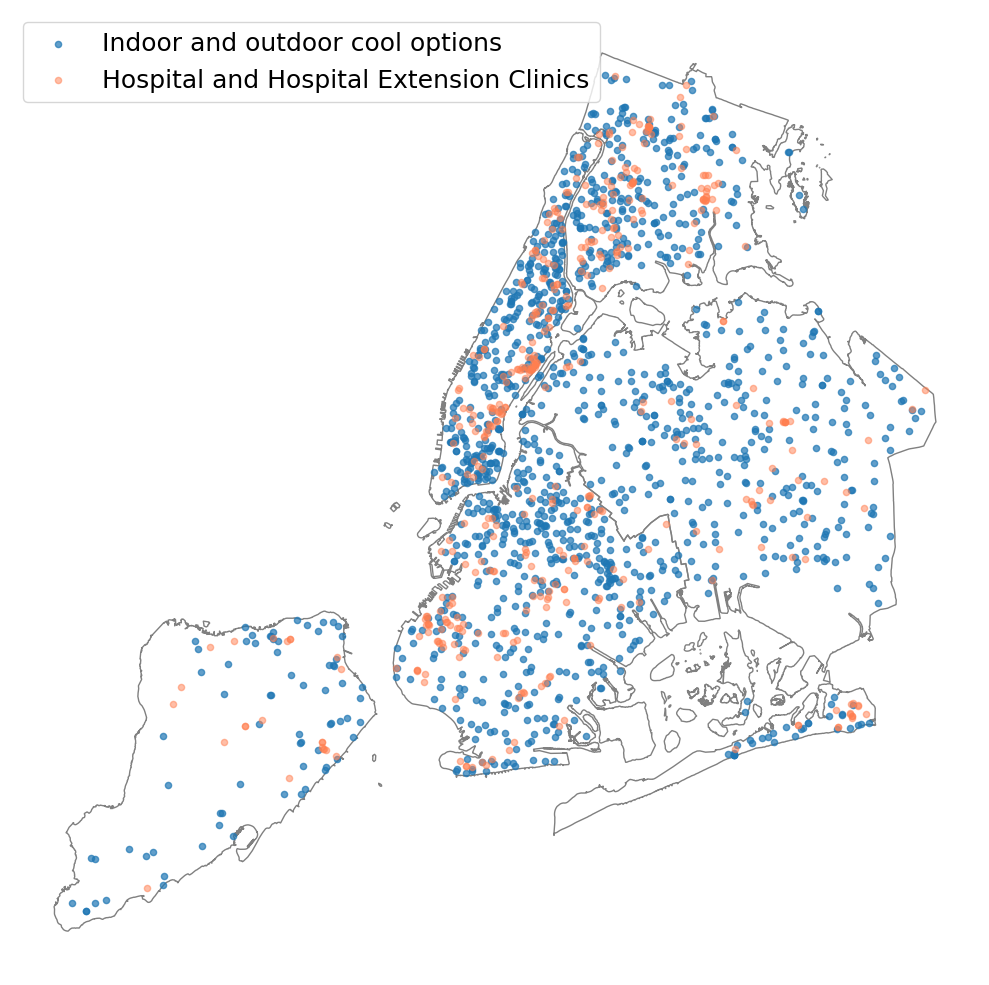

In [34]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
nyc_boros.plot(ax=ax, facecolor='none', edgecolor='gray')
#gdf_cooling_centers.plot(ax=ax, markersize=10)
gdf_cool_options.plot(ax=ax, markersize=20, alpha=0.7, label='Indoor and outdoor cool options')
gdf_healthcare_facilities.plot(ax=ax, markersize=20, c='coral', alpha=0.5, label='Hospital and Hospital Extension Clinics')
ax.set_axis_off()
plt.legend(fontsize=18)
plt.tight_layout()
plt.savefig('figures/POI_locations.pdf')
plt.show();

## Load Mobility Data

In [35]:
df_traj = pd.read_parquet(f'output/sparse_trajectories_medium.parquet')
df_traj.head()

,x,y,datetime,timestamp,user_id,ha,date,tz_offset
0,-8.227689e+06,4.970543e+06,2025-05-23 07:46:41,1748004401,admiring_curie,12.657024,2025-05-23,-18000
1,-8.227692e+06,4.970538e+06,2025-05-23 07:51:36,1748004696,admiring_curie,8.582888,2025-05-23,-18000
2,-8.227693e+06,4.970545e+06,2025-05-23 07:54:57,1748004897,admiring_curie,9.596648,2025-05-23,-18000
3,-8.227683e+06,4.970549e+06,2025-05-23 07:59:04,1748005144,admiring_curie,9.709665,2025-05-23,-18000
4,-8.227747e+06,4.970426e+06,2025-05-23 08:03:38,1748005418,admiring_curie,9.296898,2025-05-23,-18000


In [36]:
df_traj.shape, df_traj['date'].min(), df_traj['date'].max()

((239023, 8), datetime.date(2025, 5, 23), datetime.date(2025, 7, 1))

## Implement stopping algorithm using synthetic data

In [37]:
tc = {
    "user_id": "user_id",
    "timestamp": "timestamp",
    "x": "x",
    "y": "y",
    "ha":"ha",
    "date":"date",
    "tz_offset":"tz_offset"}

In [38]:
stops = LACHESIS.lachesis_per_user(df_traj, delta_roam=20, dt_max = 60, dur_min=5, complete_output=True, keep_col_names=True, traj_cols=tc)
stops

/opt/anaconda3/envs/nomad/lib/python3.14/site-packages/nomad/filters.py:111: UserWarning: Input is timezone-naive; assuming UTC. Pass tz_offset or localize if needed.
  warnings.warn(
/opt/anaconda3/envs/nomad/lib/python3.14/site-packages/nomad/filters.py:111: UserWarning: Input is timezone-naive; assuming UTC. Pass tz_offset or localize if needed.
  warnings.warn(
/opt/anaconda3/envs/nomad/lib/python3.14/site-packages/nomad/filters.py:111: UserWarning: Input is timezone-naive; assuming UTC. Pass tz_offset or localize if needed.
  warnings.warn(
/opt/anaconda3/envs/nomad/lib/python3.14/site-packages/nomad/filters.py:111: UserWarning: Input is timezone-naive; assuming UTC. Pass tz_offset or localize if needed.
  warnings.warn(
/opt/anaconda3/envs/nomad/lib/python3.14/site-packages/nomad/filters.py:111: UserWarning: Input is timezone-naive; assuming UTC. Pass tz_offset or localize if needed.
  warnings.warn(
/opt/anaconda3/envs/nomad/lib/python3.14/site-packages/nomad/filters.py:111: Use

,cluster,x,y,datetime,ha,diameter,n_pings,end_datetime,duration,max_gap,user_id
0,0,-8.227689e+06,4.970543e+06,2025-05-23 07:46:41,10.136556,14.682613,4,2025-05-23 07:59:04,12,4,admiring_curie
1,1,-8.232873e+06,4.970271e+06,2025-05-23 17:26:20,9.886225,18.731130,3,2025-05-23 17:38:51,12,6,admiring_curie
2,2,-8.227694e+06,4.970540e+06,2025-05-24 00:48:24,9.286862,16.371450,7,2025-05-24 01:42:16,53,23,admiring_curie
3,3,-8.227690e+06,4.970549e+06,2025-05-24 02:11:50,13.810382,10.380988,3,2025-05-24 02:21:54,10,9,admiring_curie
4,4,-8.227693e+06,4.970534e+06,2025-05-24 02:24:51,9.625021,7.777184,3,2025-05-24 02:55:22,30,25,admiring_curie
...,...,...,...,...,...,...,...,...,...,...,...
24427,111,-8.236556e+06,4.963811e+06,2025-06-29 22:04:06,8.736280,19.296781,3,2025-06-29 22:21:34,17,12,zen_colden
24428,112,-8.236556e+06,4.963801e+06,2025-06-29 22:33:44,11.557922,17.992127,2,2025-06-29 22:38:44,5,5,zen_colden
24429,113,-8.236569e+06,4.963789e+06,2025-06-29 22:52:07,12.423000,18.571529,6,2025-06-29 23:06:17,14,4,zen_colden
24430,114,-8.236569e+06,4.963790e+06,2025-06-29 23:38:21,12.259019,15.832511,5,2025-06-29 23:57:31,19,13,zen_colden


In [39]:
# create cool options buffer
gdf_cool_buffer = gdf_cool_options.to_crs(3857)
gdf_cool_buffer['geometry'] = gdf_cool_buffer['geometry'].buffer(30)
gdf_cool_buffer.head()

# stops to 
gdf_cooling_stops = gpd.GeoDataFrame(stops, geometry=gpd.points_from_xy(x=stops['x'], y = stops['y'], crs=3857))
gdf_cooling_stops = gdf_cooling_stops[['cluster', 'user_id', 'datetime', 'geometry']].drop_duplicates().sjoin(gdf_cool_buffer, how='left')

In [40]:
# compute visits to cooling centers
gdf_cooling_stops['date'] = pd.to_datetime(gdf_cooling_stops['datetime']).dt.date
cooling_visits_freq = gdf_cooling_stops['date'].value_counts()

<Axes: xlabel='date'>

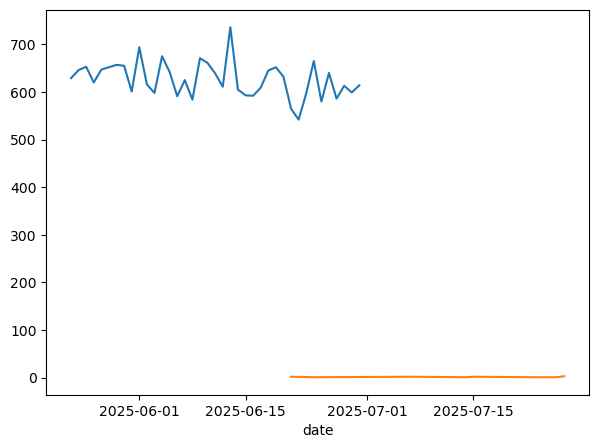

In [41]:
fig, ax = plt.subplots(1,1, figsize=(7,5))
cooling_visits_freq.sort_index().plot(ax=ax)
heat_events_daily['date'].value_counts().sort_index().plot(ax=ax)

In [42]:
heat_events_daily['date'].value_counts().sort_index()

date
2025-06-21    2
2025-06-24    1
2025-07-07    2
2025-07-14    1
2025-07-15    2
2025-07-23    1
2025-07-24    1
2025-07-26    1
2025-07-27    3
Name: count, dtype: int64

In [43]:
df_traj[['longitude','latitude']] = np.column_stack(
    filters.to_projection(df_traj, x='x', y='y', data_crs='EPSG:3857', crs_to='EPSG:4326')
)

stops_dbscan = DBSCAN.ta_dbscan_per_user(df_traj,
                    time_thresh=720,
                    dist_thresh=15,
                    min_pts=3,
                    complete_output=True,
                    traj_cols=tc)

/opt/anaconda3/envs/nomad/lib/python3.14/site-packages/nomad/filters.py:111: UserWarning: Input is timezone-naive; assuming UTC. Pass tz_offset or localize if needed.
  warnings.warn(
/opt/anaconda3/envs/nomad/lib/python3.14/site-packages/nomad/filters.py:111: UserWarning: Input is timezone-naive; assuming UTC. Pass tz_offset or localize if needed.
  warnings.warn(
/opt/anaconda3/envs/nomad/lib/python3.14/site-packages/nomad/filters.py:111: UserWarning: Input is timezone-naive; assuming UTC. Pass tz_offset or localize if needed.
  warnings.warn(
/opt/anaconda3/envs/nomad/lib/python3.14/site-packages/nomad/filters.py:111: UserWarning: Input is timezone-naive; assuming UTC. Pass tz_offset or localize if needed.
  warnings.warn(
/opt/anaconda3/envs/nomad/lib/python3.14/site-packages/nomad/filters.py:111: UserWarning: Input is timezone-naive; assuming UTC. Pass tz_offset or localize if needed.
  warnings.warn(
/opt/anaconda3/envs/nomad/lib/python3.14/site-packages/nomad/filters.py:111: Use

In [44]:
# create trajectories
gdf_cooling_stops['stopped_at_cooling_center'] = np.where(gdf_cooling_stops['index_right'].notna(),1,0)

In [45]:
gdf_cooling_stops['stopped_at_cooling_center'].mean(),\
    gdf_cooling_stops[~gdf_cooling_stops['datetime'].dt.date.isin(heat_events_daily['date'])]['stopped_at_cooling_center'].mean(),\
        gdf_cooling_stops[gdf_cooling_stops['datetime'].dt.date.isin(heat_events_daily['date'])]['stopped_at_cooling_center'].mean()

(np.float64(0.006016699410609038),
 np.float64(0.006249461253340229),
 np.float64(0.0016260162601626016))

In [46]:
gdf_stops = gpd.GeoDataFrame(stops, geometry=gpd.points_from_xy(x=stops['x'], y = stops['y'], crs=3857)).to_crs(2263)
bld_buffer = buildings.copy().to_crs(2263)
bld_buffer['geometry'] = bld_buffer['geometry'].buffer(5)
stops_bld = gdf_stops.sjoin(bld_buffer[~(bld_buffer['subtype'].isin(['park', 'parking', 'agricultural']) \
    & bld_buffer['osm_type'].isin(['park']))], how='left')

In [56]:
stops_outdoors = stops_bld[stops_bld['index_right'].isna()]
stops_indoors = stops_bld[stops_bld['index_right'].notna()]

In [57]:
stops_outdoors.shape, stops_bld['index_right'].isna().mean()

((8393, 24), np.float64(0.2968661573288059))

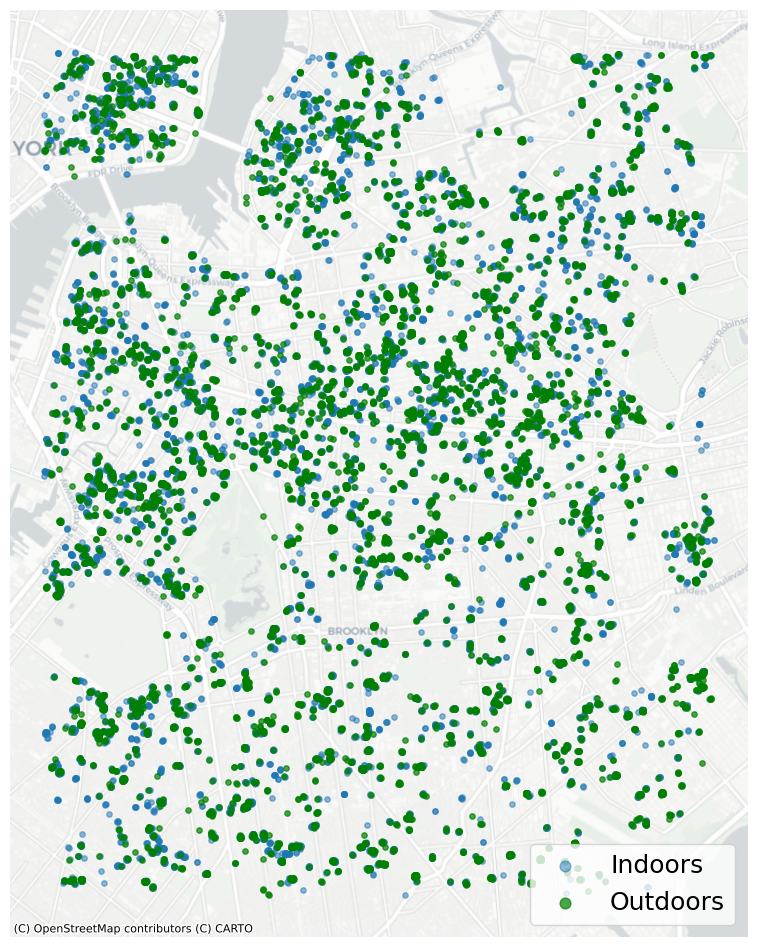

In [63]:
# Plot with contextily basemap
fig, ax = plt.subplots(figsize=(10, 10))

# Plot each agent with different color
stops_indoors.plot(ax=ax, markersize=15, label='Indoors', alpha=0.5)
stops_outdoors.plot(ax=ax, markersize=15, color='green', label='Outdoors', alpha=0.7)

# Add basemap
cx.add_basemap(ax, crs="EPSG:2263", source=cx.providers.CartoDB.Positron)
#ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', markerscale=10)
plt.tight_layout()
ax.set_axis_off()
plt.legend(fontsize=18, markerscale=2)
plt.savefig('figures/stops.pdf')
plt.show()

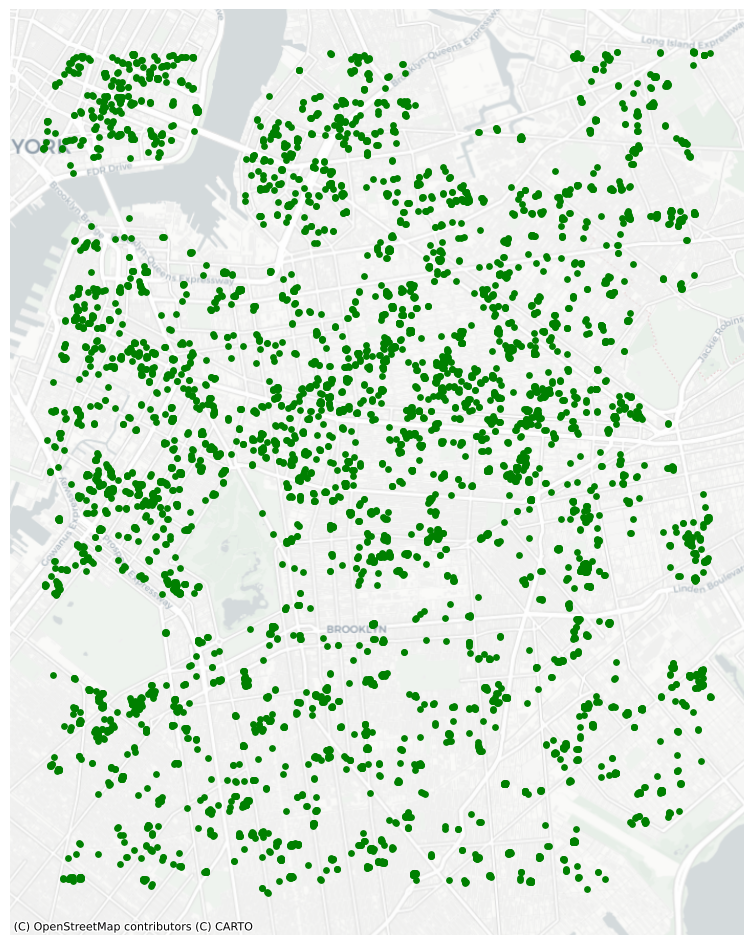

In [60]:
# Plot with contextily basemap
fig, ax = plt.subplots(figsize=(12, 10))

# Plot each agent with different color
stops_outdoors.plot(ax=ax, markersize=15, color='green')

# Add basemap
cx.add_basemap(ax, crs="EPSG:2263", source=cx.providers.CartoDB.Positron)
#ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', markerscale=10)
plt.tight_layout()
ax.set_axis_off()
plt.show()